A code example showing how to turn a NuSTAR evt file into a map using code from the [NuSTAR PySolar Repo](https://github.com/NuSTAR/nustar_pysolar)

In [3]:
import sys
from os.path import *
import os

from astropy.io import fits
import astropy.units as u

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from pylab import figure, cm
from astropy.coordinates import SkyCoord

import numpy as np

import nustar_pysolar as nustar

import sunpy.map

from scipy import ndimage

# Setup the font used for plotting
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 18

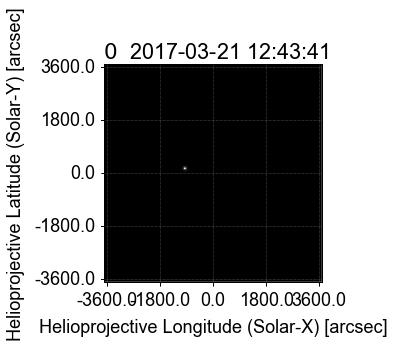

In [4]:
dirin='/Users/iain/data/heasarc_nustar/ns_20170321/20210015001/event_cl/'
infile = 'nu20210015001A06_cl_sunpos.evt'

# Load in the evt
hdulist = fits.open(dirin+infile)
evtdata=hdulist[1].data
hdr = hdulist[1].header
hdulist.close()

# Filter the evt file
cleanevt = nustar.filter.event_filter(evtdata,fpm='B',energy_low=2.5, energy_high=5.0)

# Map the filtered evt, into one corrected for livetime (so units count/s) 
nustar_map = nustar.map.make_sunpy(cleanevt, hdr,norm_map=True)

#Apply a guassian blur to the data to bring out the faint feature
dd=ndimage.gaussian_filter(nustar_map.data, 4, mode='nearest')

# Tidy things up before plotting
dmin=1e-3
dmax=1e1
dd[dd < dmin]=0
nm=sunpy.map.Map(dd, nustar_map.meta)

# Immeditate plot to check ok
nm.plot()
plt.show()


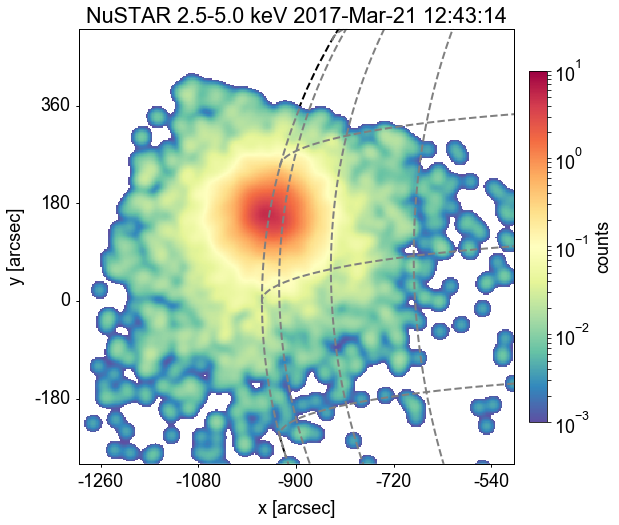

In [5]:
# Submap to plot
bl = SkyCoord(-1300*u.arcsec, -300*u.arcsec, frame=nm.coordinate_frame)
tr = SkyCoord(-500*u.arcsec, 500*u.arcsec, frame=nm.coordinate_frame)
nustar_submap = nm.submap(bl,tr)

# Setup the scaling of the map and colour table
nustar_submap.plot_settings['norm'] = colors.LogNorm(vmin=dmin,vmax=dmax)
nustar_submap.plot_settings['cmap'] = cm.get_cmap('Spectral_r')

#can rebin the pixels if we want to further bring out faint features
nx,ny=np.shape(nustar_submap.data)
#set to 1 means no actual rebinning
rebin_npix=1.
dimensions = u.Quantity([nx/rebin_npix, ny/rebin_npix], u.pixel)
rsn_map=nustar_submap.resample(dimensions)

# Start the plot - many things here just to make matplotlib look decent
fig = plt.figure(figsize=(9, 8))
ax = plt.subplot(projection=rsn_map)

rsn_map.plot()
rsn_map.draw_limb(color='black',linewidth=2,linestyle='dashed',zorder=0)   

# Manually plot a heliographic overlay - hopefully future no_ticks option in draw_grid
overlay = ax.get_coords_overlay('heliographic_stonyhurst')
lon = overlay[0]
lat = overlay[1]
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticklabel_visible(False)
lon.coord_wrap = 180
lon.set_major_formatter('dd')
overlay.grid(color='grey', linewidth=2, linestyle='dashed')

# Tweak the titles and labels
title_obsdate='{:.20}'.format('{:%Y-%b-%d %H:%M:%s}'.format(rsn_map.date))
ax.set_title('NuSTAR 2.5-5.0 keV '+ title_obsdate)
ax.set_ylabel('y [arcsec]')
ax.set_xlabel('x [arcsec]')
tx, ty = ax.coords
tx.set_major_formatter('s')
ty.set_major_formatter('s')
ax.grid(False)
# Add a colour bar
plt.colorbar(fraction=0.035, pad=0.03,label='counts')
plt.show()